In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utilities import (
    process_leveraged_data, 
    find_ath_indices, 
    calculate_ath_returns_all_periods, 
    calculate_non_ath_returns_all_periods
)

In [ ]:
# Define inputs
tickers = ["QQQ", "SPY", "SOXX"]
leverage_scalars = [3, 3, 3]  # Leverage scalars for each respective ticker
portfolio_weights = [0.6, 0.2, 0.2]  # Portfolio weights summing to 1.0

# Process the data
data = process_leveraged_data(tickers, leverage_scalars, portfolio_weights)
data.head()

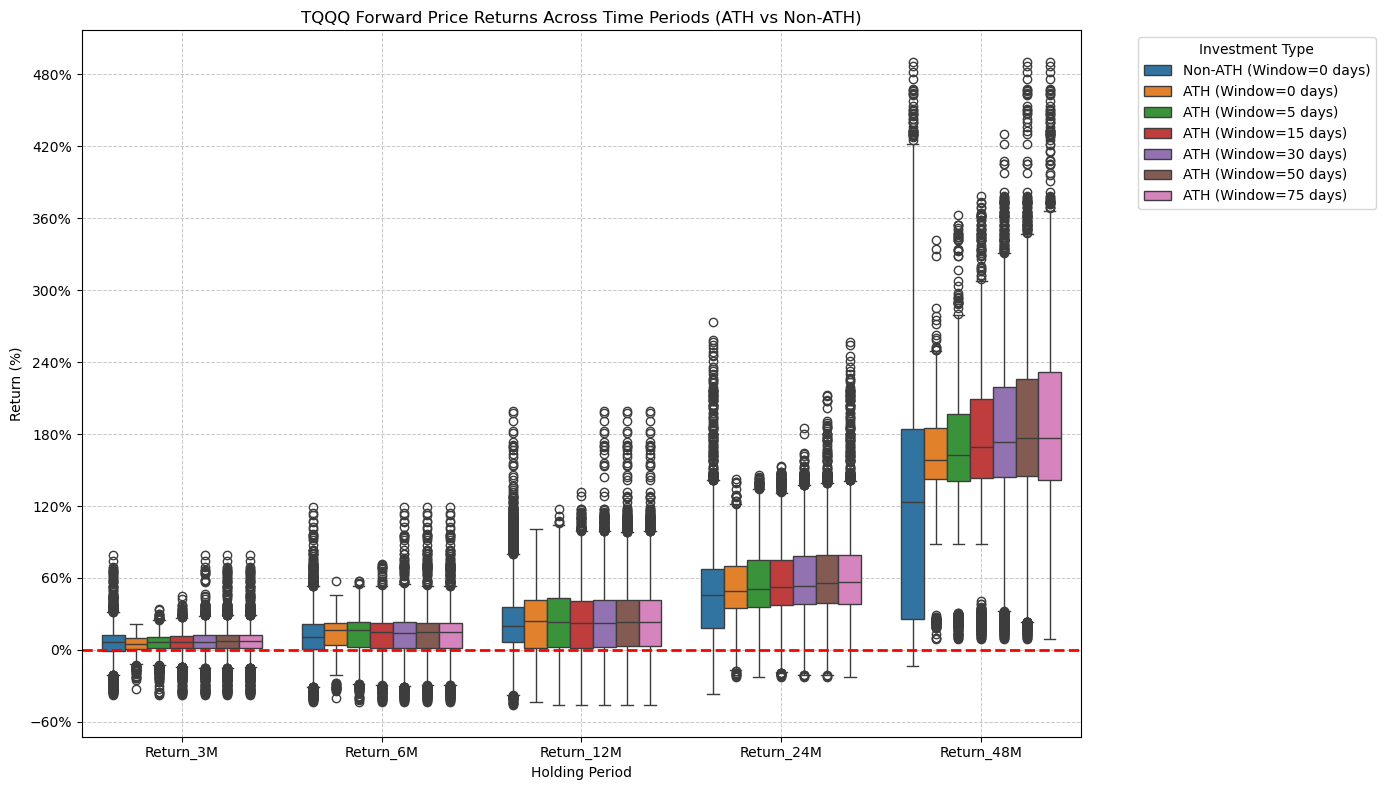

In [3]:
# Window sizes
windows = [0, 5, 15, 30, 50, 75]
combined_results = []
for w in windows:
    ############### this is now only lookin at when our portfolio is at an ath. Maybe change this?   #############
    ath_indices_leveraged = find_ath_indices(data, 'TotalPortfolioPrice', window=w)

    # ATH returns
    ath_returns_df = calculate_ath_returns_all_periods(data, ath_indices_leveraged)
    non_ath_returns_df = calculate_non_ath_returns_all_periods(data, ath_indices_leveraged)

    # Add group flag
    ath_returns_df['Group'] = f'ATH (Window={w} days)'
    if w == 0:
        non_ath_returns_df['Group'] = 'Non-ATH (Window=0 days)'
        combined_results.append(non_ath_returns_df)  # Only include non-ATH data for Window=0

    # Combine results
    combined_results.append(ath_returns_df)

# # Join to a single df
final_combined_df = pd.concat(combined_results)

# Melt DataFrame for the two groups & their holding periods
melted_df = final_combined_df.melt(
    id_vars=['Group'], 
    value_vars=['Return_3M', 'Return_6M', 'Return_12M', 'Return_24M', 'Return_48M'], 
    var_name='Holding Period', 
    value_name='Return'
)

# Create boxplots
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=melted_df, 
    x='Holding Period', 
    y='Return', 
    hue='Group', 
    palette='tab10'
)

from matplotlib.ticker import PercentFormatter, MaxNLocator
# Customize plot aesthetics
plt.title('TQQQ Forward Price Returns Across Time Periods (ATH vs Non-ATH)')
plt.xlabel('Holding Period')
plt.ylabel('Return (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # y-axis as percentages
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=10))  # Add more ticks on the y-axis
plt.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)  # Add a grid
plt.axhline(0, color='red', linestyle='--', linewidth=2)  # Add a baseline for 0% return
plt.legend(title='Investment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()
